In [1]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

df = pd.read_excel("../data/underlying_assets.xlsx", engine="openpyxl")

first_star = df[df.Name == "삼성전자"]
second_star = df[df.Name == "현대차"]

df.head()

,Name,Date,Close
0,삼성전자,2016-06-01,26660
1,삼성전자,2016-06-02,27300
2,삼성전자,2016-06-03,27540
3,삼성전자,2016-06-07,27960
4,삼성전자,2016-06-08,28120


In [22]:
def preprocess(first_star, second_star):
        first_star_s0 = first_star.iloc[-1]
        second_star_s0 = second_star.iloc[-1]
        
        first_star_profit_rate = first_star.iloc[:-2].pct_change()
        second_star_profit_rate = second_star.iloc[:-2].pct_change()
        
        first_star_annualized_volatiliy = first_star_profit_rate.std() * math.sqrt(252)
        second_star_annualized_volatiliy = second_star_profit_rate.std() * math.sqrt(252)
        
        corrcoef = np.corrcoef(first_star_profit_rate[1:], second_star_profit_rate[1:])

        k_mat = np.linalg.cholesky(corrcoef)
        
        return first_star_s0, second_star_s0, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat
        
        
def MCMC(first_star_s0, second_star_s0, 
         first_star_annualized_volatiliy, second_star_annualized_volatiliy,
         k_mat, simulation_duration, 
         riskfree_rate=0.15, delta_t=1/252,
         n_simulation=1000):
    
    episodes = []

    for i in range(n_simulation):
        episode = generate_episode(
            first_star_s0, second_star_s0, 
            first_star_annualized_volatiliy, second_star_annualized_volatiliy,
            k_mat, simulation_duration
        )
        episodes.append(episode)
        
    return episodes
    
    
def generate_episode(first_star_s0, second_star_s0, 
                     first_star_annualized_volatiliy, second_star_annualized_volatiliy,
                     k_mat, simulation_duration, 
                     riskfree_rate=0.15, delta_t=1/252):
    
    first_star_episode = []
    second_star_episode = []

    first_star_price = first_star_s0
    second_star_price = second_star_s0
    
    w0 = np.random.normal(0, 1, [simulation_duration, 2]).T
    w = np.matmul(k_mat, w0)

    first_star_random_walk = np.exp((riskfree_rate - 0.5 * first_star_annualized_volatiliy ** 2) * delta_t + first_star_annualized_volatiliy * w[0, :] * np.sqrt(delta_t))
    second_star_random_walk = np.exp((riskfree_rate - 0.5 * second_star_annualized_volatiliy ** 2) * delta_t + second_star_annualized_volatiliy * w[1, :] * np.sqrt(delta_t))

    for i in range(simulation_duration):
        first_star_price *= first_star_random_walk[i]
        second_star_price *= second_star_random_walk[i]

        first_star_episode.append(first_star_price)
        second_star_episode.append(second_star_price)

    episode = np.vstack([first_star_episode, second_star_episode])

    return np.round(episode)


def valuation(s0, episodes, date_distance, 
              strike_price, coupon_rate,
              knock_in_barrier=0.55,
              riskfree_rate=0.15, investment_amount=100000000):
    
    bussiness_date_distance = date_distance - 1
    bussiness_date_distance = bussiness_date_distance[bussiness_date_distance > 0]
    date_distance = date_distance[-len(bussiness_date_distance):]
    coupon_rate = coupon_rate[-len(bussiness_date_distance):]
    strike_price = strike_price[-len(bussiness_date_distance):]
    discounted_pay_off = 0

    for episode in episodes:
        is_payoff = False
        for i in range(len(strike_price)):            
            performance = np.divide(episode[:, bussiness_date_distance], np.repeat(s0, len(strike_price)).reshape(2, -1))
            worst_performance = np.min(performance, axis=0)
            worst_performance_index = np.where(performance == worst_performance)[0]
            
            if worst_performance[i] >= strike_price[i]:
                discounted_pay_off += np.sum(investment_amount * (1 + coupon_rate[i])) * np.exp(-riskfree_rate * bussiness_date_distance[i] / 252)
                is_payoff = True
                break

        if worst_performance[i] > knock_in_barrier and is_payoff == False:
            discounted_pay_off += np.sum(investment_amount * (1 + coupon_rate[-1])) * np.exp(-riskfree_rate * bussiness_date_distance[-1] / 252)
        elif worst_performance[i] <= knock_in_barrier and is_payoff == False:
            discounted_pay_off += (investment_amount * worst_performance[-1] / s0[worst_performance_index[-1]]) * np.exp(-riskfree_rate * bussiness_date_distance[-1] / 252)

    npv = int(discounted_pay_off / len(episodes))

    return npv


In [23]:
def get_rebalancing_date(df):
    df.loc[:, 'year'] = df.Date.dt.year
    df.loc[:, 'week'] = df.Date.dt.week
    df.loc[:, 'dayofweek'] = df.Date.dt.dayofweek
    
    rebalancing_date = df.loc[df.groupby(['year', 'week']).dayofweek.idxmin(), "Date"].iloc[57:].reset_index(drop=True)
    
    return rebalancing_date


def scenario_based_els_value(first_star_s0, second_star_s0, 
                             first_star_annualized_volatiliy, second_star_annualized_volatiliy,
                             k_mat, simulation_duration):

    episodes = MCMC(first_star_s0, second_star_s0, 
                    first_star_annualized_volatiliy, second_star_annualized_volatiliy,
                    k_mat, simulation_duration=simulation_date, 
                    riskfree_rate=0.15, delta_t=1/252,
                    n_simulation=1000)
    
    s0 = np.array([first_star_s0, second_star_s0])
    ELS_value = valuation(s0, episodes, date_distance,
                          strike_price, coupon_rate)
    
    return ELS_value


def compute_delta(first_star_s0_up, first_star_s0_down,
                  second_star_s0_up, second_star_s0_down,
                  first_up_second_hold_scenario, first_down_second_hold_scenario, 
                  first_hold_second_up_scenario, first_hold_second_down_scenario):
    
    els_delta_1 = (first_up_second_hold_scenario - first_down_second_hold_scenario) / (first_star_s0_up - first_star_s0_down)
    els_delta_2 = (first_hold_second_up_scenario - first_hold_second_down_scenario) / (second_star_s0_up - second_star_s0_down)
    
    return els_delta_1, els_delta_2


def run(first_star_price, second_star_price, start_date):
    first_star_s0, second_star_s0, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat = preprocess(first_star_price[:start_date], second_star_price[:start_date])

    first_star_s0_up = first_star_s0 * math.exp(first_star_annualized_volatiliy * math.sqrt(5 * 1/252))
    first_star_s0_down = first_star_s0 * math.exp(first_star_annualized_volatiliy * - math.sqrt(5 * 1/252))

    second_star_s0_up = second_star_s0 * math.exp(second_star_annualized_volatiliy * math.sqrt(5 * 1/252))
    second_star_s0_down = second_star_s0 * math.exp(second_star_annualized_volatiliy * - math.sqrt(5 * 1/252))

    first_up_second_hold_scenario = scenario_based_els_value(first_star_s0_up, second_star_s0, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat, simulation_duration=simulation_date)
    first_down_second_hold_scenario = scenario_based_els_value(first_star_s0_down, second_star_s0, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat, simulation_duration=simulation_date)

    first_hold_second_up_scenario = scenario_based_els_value(first_star_s0, second_star_s0_up, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat, simulation_duration=simulation_date)
    first_hold_second_down_scenario = scenario_based_els_value(first_star_s0, second_star_s0_down, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat, simulation_duration=simulation_date)
    
    els_value = scenario_based_els_value(first_star_s0, second_star_s0, first_star_annualized_volatiliy, second_star_annualized_volatiliy, k_mat, simulation_duration=simulation_date)
    
    els_delta_1, els_delta_2 = compute_delta(first_star_s0_up, first_star_s0_down,
                                             second_star_s0_up, second_star_s0_down,
                                             first_up_second_hold_scenario, first_down_second_hold_scenario, 
                                             first_hold_second_up_scenario, first_hold_second_down_scenario)

    return els_value, els_delta_1, els_delta_2




In [24]:
strike_price = [0.87, 0.87, 0.87, 0.85, 0.85, 0.85]
coupon_rate = np.array([0.0475, 0.095, 0.1425, 0.19, 0.2375, 0.285])
knock_in_barrier = np.array([0.55])
riskfree_rate = 0.015

rebalancing_date = get_rebalancing_date(df)

first_star_price = first_star.set_index("Date").Close
second_star_price = second_star.set_index("Date").Close

/var/folders/nw/x1lqw0rx1mj698bqcgqxhk880000gn/T/ipykernel_38670/3670720349.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df.loc[:, 'week'] = df.Date.dt.week


In [25]:
delta_results = []

starting_date = "2017/06/30"
checking_date = ["2017/12/21", "2018/06/26", "2018/12/20", "2019/06/25", "2019/12/19", "2020/06/25"]
date_distance = np.array([len(first_star_price.loc[starting_date:date]) for date in checking_date])
simulation_date = date_distance[-1]

els_value, els_delta_1, els_delta_2 = run(first_star_price, second_star_price, starting_date)
delta_results.append([starting_date, els_value, els_delta_1, els_delta_2])

for d in tqdm(rebalancing_date):
    try:
        starting_date = d
        checking_date = ["2017/12/21", "2018/06/26", "2018/12/20", "2019/06/25", "2019/12/19", "2020/06/25"]
        date_distance = np.array([len(first_star_price.loc[starting_date:date]) for date in checking_date])
        simulation_date = date_distance[-1]

        els_value, els_delta_1, els_delta_2 = run(first_star_price, second_star_price, starting_date)
        delta_results.append([starting_date, els_value, els_delta_1, els_delta_2])
    except:
        pass
    
delta_results = pd.DataFrame(delta_results, columns=["Date", "ELS value", "ELS Delta 1", "ELS Delta 2"])
delta_results

100%|█████████████████████████████████████████| 156/156 [01:46<00:00,  1.46it/s]
/var/folders/nw/x1lqw0rx1mj698bqcgqxhk880000gn/T/ipykernel_38670/4279368078.py:23: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  delta_results = pd.DataFrame(delta_results, columns=["Date", "ELS value", "ELS Delta 1", "ELS Delta 2"])


,Date,ELS value,ELS Delta 1,ELS Delta 2
0,2017-06-30,93649661,-65.363097,-76.641583
1,2017-07-03,93264508,-184.447939,-20.335094
2,2017-07-10,94564467,-78.706323,-68.756077
3,2017-07-17,94895344,-283.143191,-41.668741
4,2017-07-24,95049211,274.595769,12.372553
...,...,...,...,...
151,2020-05-25,126752761,0.000000,0.000000
152,2020-06-01,127130563,0.000000,0.000000
153,2020-06-08,127509492,0.000000,0.000000
154,2020-06-15,127889549,0.000000,0.000000


In [31]:
delta_results.head(10)

,Date,ELS value,ELS Delta 1,ELS Delta 2
0,2017-06-30,93649661,-65.363097,-76.641583
1,2017-07-03,93264508,-184.447939,-20.335094
2,2017-07-10,94564467,-78.706323,-68.756077
3,2017-07-17,94895344,-283.143191,-41.668741
4,2017-07-24,95049211,274.595769,12.372553
5,2017-07-31,96149210,-62.755006,-29.749628
6,2017-08-07,95639365,213.507353,-32.897880
7,2017-08-14,96917937,130.816961,-36.048879
8,2017-08-21,96394567,17.301250,37.000225
9,2017-08-28,97799547,-98.410256,-113.518807


In [30]:
delta_results.to_excel("dynamic hedging table.xlsx")

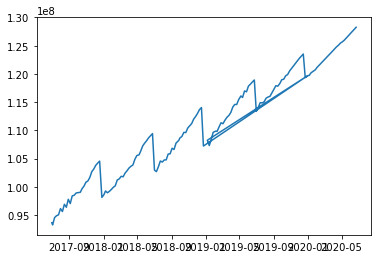

In [29]:
import matplotlib.pyplot as plt

plt.plot(delta_results['Date'], delta_results['ELS value'])

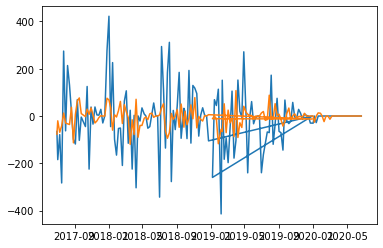

In [27]:
plt.plot(delta_results['Date'], delta_results['ELS Delta 1'])
plt.plot(delta_results['Date'], delta_results['ELS Delta 2'])